IMPORT MODULES

In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

DATASET AND DATALOADER

Class

In [2]:
class Dataset(Dataset):
    def __init__(self,X,Y):
        self.Y = Y
        self.X = X.float()
        self.X = self.X.view(len(X),-1)
        self.mean = self.X.mean((0))
        self.std = self.X.std((0))
        self.X -= self.mean
        for i in range(len(self.X[0])):
            if self.std[i] != 0: #to avoid division by zero
                self.X[:,i] /= self.std[i]
    def __getitem__(self,index):
        return self.X[index],self.Y[index]
    def __len__(self):
        return len(self.X)

In [3]:
# #dataset from datamaestro
# from datamaestro import prepare_dataset
# ds = prepare_dataset ( "com.lecun.mnist" ) ;
# train_images , train_labels = ds.files["train/images" ].data(),  ds.files[ "train/labels" ].data()
# test_images , test_labels = ds.files["test/images" ].data(),  ds.files[ "test/labels" ].data()

Dataset

In [4]:
#dataset from torchvision
from torchvision.datasets import MNIST
dataset = MNIST('./data',train=True,download=True)
train_images , train_labels = dataset.train_data,dataset.train_labels
test_images, test_labels = dataset.test_data,dataset.test_labels
train_data = Dataset(train_images,train_labels)

C:\Users\Jp\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Jp\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Jp\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Jp\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Dataload

In [5]:
#dataload
batch_size = 2
train_loader = DataLoader(Dataset(train_data.X,train_data.Y),shuffle=True,batch_size=batch_size)
i = 0
for x,y in train_loader:
    if i>3:
        break
    print(x,y)
    i += 1

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([0, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([2, 2])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([9, 7])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([8, 5])


AUTOENCODER

In [6]:
#autoencoder and state classes
class Autoencoder(torch.nn.Module):
    def __init__(self,D_in,D_h):
        super(Autoencoder,self).__init__()
        self.linear = torch.nn.Linear(D_in,D_h)
        self.ReLU = torch.nn.ReLU()

    def forward(self,x):
        encoded = self.ReLU(self.linear(x))
        reconstruct = torch.sigmoid(torch.matmul(encoded,self.linear.weight))
        return reconstruct

class State:
    def __init__(self,model,optim,list_loss,epoch,iteration):
        self.model = model
        self.optim = optim
        self.list_loss = list_loss
        self.epoch = epoch
        self.iteration = iteration

Initialization

In [7]:
from pathlib import Path
#data
D_in,D_h = len(train_images[0])*len(train_images[0][0]),256

#params
lr = 1e-3
nb_epoch = 2
batch_size = 128

#model 
#Get params back
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
savepath = Path("/")
if savepath.is_file():
    with savepath.open("rb") as fp:
        state = torch.load(fp)
else:
    model = Autoencoder(D_in,D_h)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    state = State(model,optimizer,[],0,0)

Run the model

In [8]:
#descent
for i in range(state.epoch, nb_epoch):
    for x,y in train_loader:
        #zero grad
        state.optim.zero_grad()
        #gpu and forward
        x = x.to(device)
        xhat = model(x)
        #loss
        loss = loss_fn(xhat,x)
        #backpropagation
        loss.backward()
        #update state
        state.optim.step()
        state.iteration += 1
    train_data.X = train_data.X.to(device)
    state.list_loss.append(loss_fn(train_data.X,model(train_data.X)))
    state.epoch += 1
    #TO DO : fix savepath on windows
    #with savepath.open("wb") as fp:
        #torch.save(state,fp)
        

Visualization

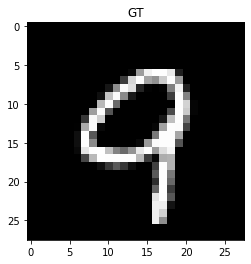

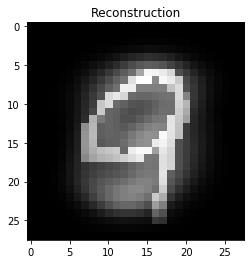

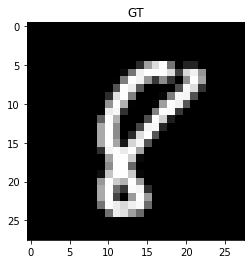

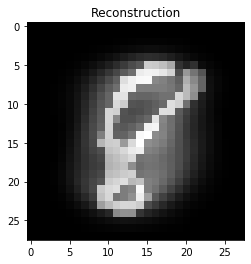

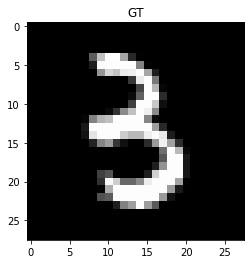

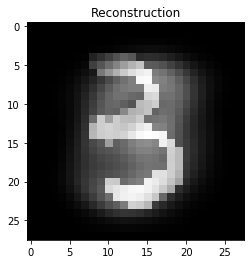

In [9]:
indices = np.random.choice(len(train_data),3,replace= False)
# go back to cpu
model = model.to(torch.device('cpu'))
train_data.X = train_data.X.to(torch.device('cpu'))
for i in range(len(indices)):
    ind = indices[i]
    x = train_data.X[ind]
    x = (model(x)*train_data.std+train_data.mean).int()
    plt.figure()
    plt.title("GT")
    plt.imshow(train_images[ind],cmap='gray')
    plt.figure()
    plt.title("Reconstruction")
    plt.imshow(x.view(28,28).detach().numpy(),cmap='gray')

Tensorboard

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
for i in range(len(state.list_loss)):
    writer.add_scalar('Train_cost', state.list_loss[i].item(), i)
    #writer.add_scalar('Test_cost', test_loss[i].item(), i)
writer.close()

HIGHWAY NETWORKS

Highway layer

In [11]:
class highway_Layer(torch.nn.Module):
    def __init__(self,D,linear_activ,gate_activ):
        super(highway_Layer,self).__init__()
        self.linear = torch.nn.Linear(D,D)
        self.linear_activ = linear_activ
        self.gate = torch.nn.Linear(D,D)
        self.gate_activ = gate_activ
    
    def forward(self,x):
        T = self.gate_activ(self.gate(x))
        H = self.linear_activ(self.linear(x))
        return torch.add(torch.mul(H,T),torch.mul(1.-T,x))

In [12]:
model2 = highway_Layer(5,torch.nn.ReLU(),torch.nn.Sigmoid())
print(model2)

highway_Layer(
  (linear): Linear(in_features=5, out_features=5, bias=True)
  (linear_activ): ReLU()
  (gate): Linear(in_features=5, out_features=5, bias=True)
  (gate_activ): Sigmoid()
)


Highway network

In [13]:
class highway_Network(torch.nn.Module):
    def __init__(self,D_in,D_hid,D_out,number_layers,linear_activ,gate_activ):
        super(highway_Network,self).__init__()
        self.linear_in = torch.nn.Linear(D_in,D_hid)
        self.highway_Layers = torch.nn.ModuleList([highway_Layer(D_hid,linear_activ,gate_activ) for i in range(number_layers)])
        self.linear_out = torch.nn.Linear(D_hid,D_out)
    def forward(self,x):
        x = self.linear_in(x)
        for layer in self.highway_layers:
            x = layer(x)
        x = self.linear_out(x)
        return x

In [14]:
model3 = highway_Network(5,3,5,3,torch.nn.ReLU(),torch.nn.Sigmoid())
print(model3)

highway_Network(
  (linear_in): Linear(in_features=5, out_features=3, bias=True)
  (highway_Layers): ModuleList(
    (0): highway_Layer(
      (linear): Linear(in_features=3, out_features=3, bias=True)
      (linear_activ): ReLU()
      (gate): Linear(in_features=3, out_features=3, bias=True)
      (gate_activ): Sigmoid()
    )
    (1): highway_Layer(
      (linear): Linear(in_features=3, out_features=3, bias=True)
      (linear_activ): ReLU()
      (gate): Linear(in_features=3, out_features=3, bias=True)
      (gate_activ): Sigmoid()
    )
    (2): highway_Layer(
      (linear): Linear(in_features=3, out_features=3, bias=True)
      (linear_activ): ReLU()
      (gate): Linear(in_features=3, out_features=3, bias=True)
      (gate_activ): Sigmoid()
    )
  )
  (linear_out): Linear(in_features=3, out_features=5, bias=True)
)
